# 0.0 Imports

In [1]:
import warnings
import inflection

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

## 0.1 Load data

In [2]:
video_game_data = catalog.load("video_game_data")

[09/21/23 21:57:10] INFO     Loading data from 'video_game_data' (CSVDataSet)...                ]8;id=838496;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=665822;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#492\492]8;;\

## 0.2 Helper Functions

In [3]:
def notebook_settings():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [28, 12]
    plt.rcParams['font.size'] = 24
    sns.set()

    warnings.filterwarnings('ignore')
    return None

notebook_settings()

# 1.0 Data Description

In [4]:
video_game_data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.000,Sports,Nintendo,41.490,29.020,3.770,8.460,82.740
1,2,Super Mario Bros.,NES,1985.000,Platform,Nintendo,29.080,3.580,6.810,0.770,40.240
2,3,Mario Kart Wii,Wii,2008.000,Racing,Nintendo,15.850,12.880,3.790,3.310,35.820
3,4,Wii Sports Resort,Wii,2009.000,Sports,Nintendo,15.750,11.010,3.280,2.960,33.000
4,5,Pokemon Red/Pokemon Blue,GB,1996.000,Role-Playing,Nintendo,11.270,8.890,10.220,1.000,31.370


## 1.1 Rename Columns

In [5]:
snakecase = lambda x: inflection.underscore(x)

video_game_data.columns = [snakecase(column) for column in video_game_data.columns]

## 1.2 Data Dimension

In [6]:
print(f'Number os rows: {video_game_data.shape[0]}')
print(f'Number os columns: {video_game_data.shape[1]}')

Number os rows: 16598
Number os columns: 11


## 1.3 Check NA

In [7]:
video_game_data.isna().sum() / video_game_data.shape[0] * 100


rank           0.000
name           0.000
platform       0.000
year           1.633
genre          0.000
publisher      0.349
na_sales       0.000
eu_sales       0.000
jp_sales       0.000
other_sales    0.000
global_sales   0.000
dtype: float64

## 1.4 Fillout NA

- year: First we can understand that the amount of missing data is small, so that the absence of this data does not considerably harm. That said, a replacement with a mean or median grouped by publisher could be another alternative, and collecting this data via external means requires significant effort (although it could be used in a second cycle).
- publisher: This data can also be removed, however we can isolate it with a new label, this can be useful in the situation of analyzing if the data has any deviant behavior.

In [8]:
video_game_data = video_game_data.dropna(subset=['year'])
video_game_data['publisher'].fillna('others_publishers', inplace=True)

video_game_data.isna().sum() / video_game_data.shape[0] * 100


rank           0.000
name           0.000
platform       0.000
year           0.000
genre          0.000
publisher      0.000
na_sales       0.000
eu_sales       0.000
jp_sales       0.000
other_sales    0.000
global_sales   0.000
dtype: float64

## 1.5 Data Types

In [9]:
video_game_data.dtypes


rank              int64
name             object
platform         object
year            float64
genre            object
publisher        object
na_sales        float64
eu_sales        float64
jp_sales        float64
other_sales     float64
global_sales    float64
dtype: object

- The only incorrect type would be the year

In [10]:
video_game_data['year'] = video_game_data['year'].astype('int64')

video_game_data.dtypes


rank              int64
name             object
platform         object
year              int64
genre            object
publisher        object
na_sales        float64
eu_sales        float64
jp_sales        float64
other_sales     float64
global_sales    float64
dtype: object

## 1.6 Descriptive Statistical

In [11]:
df_aux = video_game_data.copy()

num_attributes = df_aux.select_dtypes(include=['int64', 'float64'])
cat_attributes = df_aux.select_dtypes(exclude=['int64', 'float64'])

### 1.6.1 Numerical Attributes

In [12]:
# Central tendency and Dispersion
range_values = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
statistic_metric = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# Concatenate
metrics = pd.concat([range_values, statistic_metric]).T.reset_index()
metrics.columns = ['attibutes', 'range', 'min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics = metrics[['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]

metrics

,attibutes,min,max,range,mean,median,std,skew,kurtosis
0,rank,1.000,16600.000,16599.000,8292.868,8295.000,4792.670,0.001,-1.200
1,year,1980.000,2020.000,40.000,2006.406,2007.000,5.829,-1.003,1.848
2,na_sales,0.000,41.490,41.490,0.265,0.080,0.822,18.758,644.149
3,eu_sales,0.000,29.020,29.020,0.148,0.020,0.509,18.794,747.968
4,jp_sales,0.000,10.220,10.220,0.079,0.000,0.312,11.136,191.609
5,other_sales,0.000,10.570,10.570,0.048,0.010,0.190,24.126,1014.006
6,global_sales,0.010,82.740,82.730,0.540,0.170,1.566,17.321,597.179


Each piece of information may contain information, but I will list the most relevant:
- We have no negative sales, which could be considered a mistake
- An initial analysis shows the importance of sales in the order of: NA > EU > JP > Others, this may show that the data has already been collected initially on the basis of market relevance, however this should remain a premise.
- The sales skew could mean a Poisson distribution, which is very characteristic in these scenarios due to the sales funnel.

In [13]:
print(f"percentage of unique values in the ranking correspond to {len(num_attributes['rank'].unique()) / video_game_data.shape[0] * 100} % of rows in the dataframe")

percentage of unique values in the ranking correspond to 100.0 % of rows in the dataframe


- Although the ranking varies between 1 and 16600, the unique values correspond to 100% of the size of the rows, which indicates that the ranking is unique, the biggest doubt is why the values are not sequential (between 1 and 16327).

In [14]:
num_attributes['total_sales'] = num_attributes[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
is_close = np.isclose(num_attributes['total_sales'], video_game_data['global_sales'], atol=0.1)
percentage_matching = is_close.mean() * 100

print(f"{percentage_matching:.2f}% of the rows have the column 'total_sales' approximately equal to 'global_sales' within the margin of 0.1.")

100.00% of the rows have the column 'total_sales' approximately equal to 'global_sales' within the margin of 0.1.


- The check above highlights that the `global_sales` column is actually a feature making up the sum of global market sales.

### 1.6.2 Categorical Attributes

In [15]:
# checking data variation
cat_attributes.apply(lambda x: x.unique().shape[0])


name         11360
platform        31
genre           12
publisher      577
dtype: int64

- The cardinality is considerable and can have an impact on analysis and visualization, so let's look at the platform and genre that contain the lowest cardinalities.

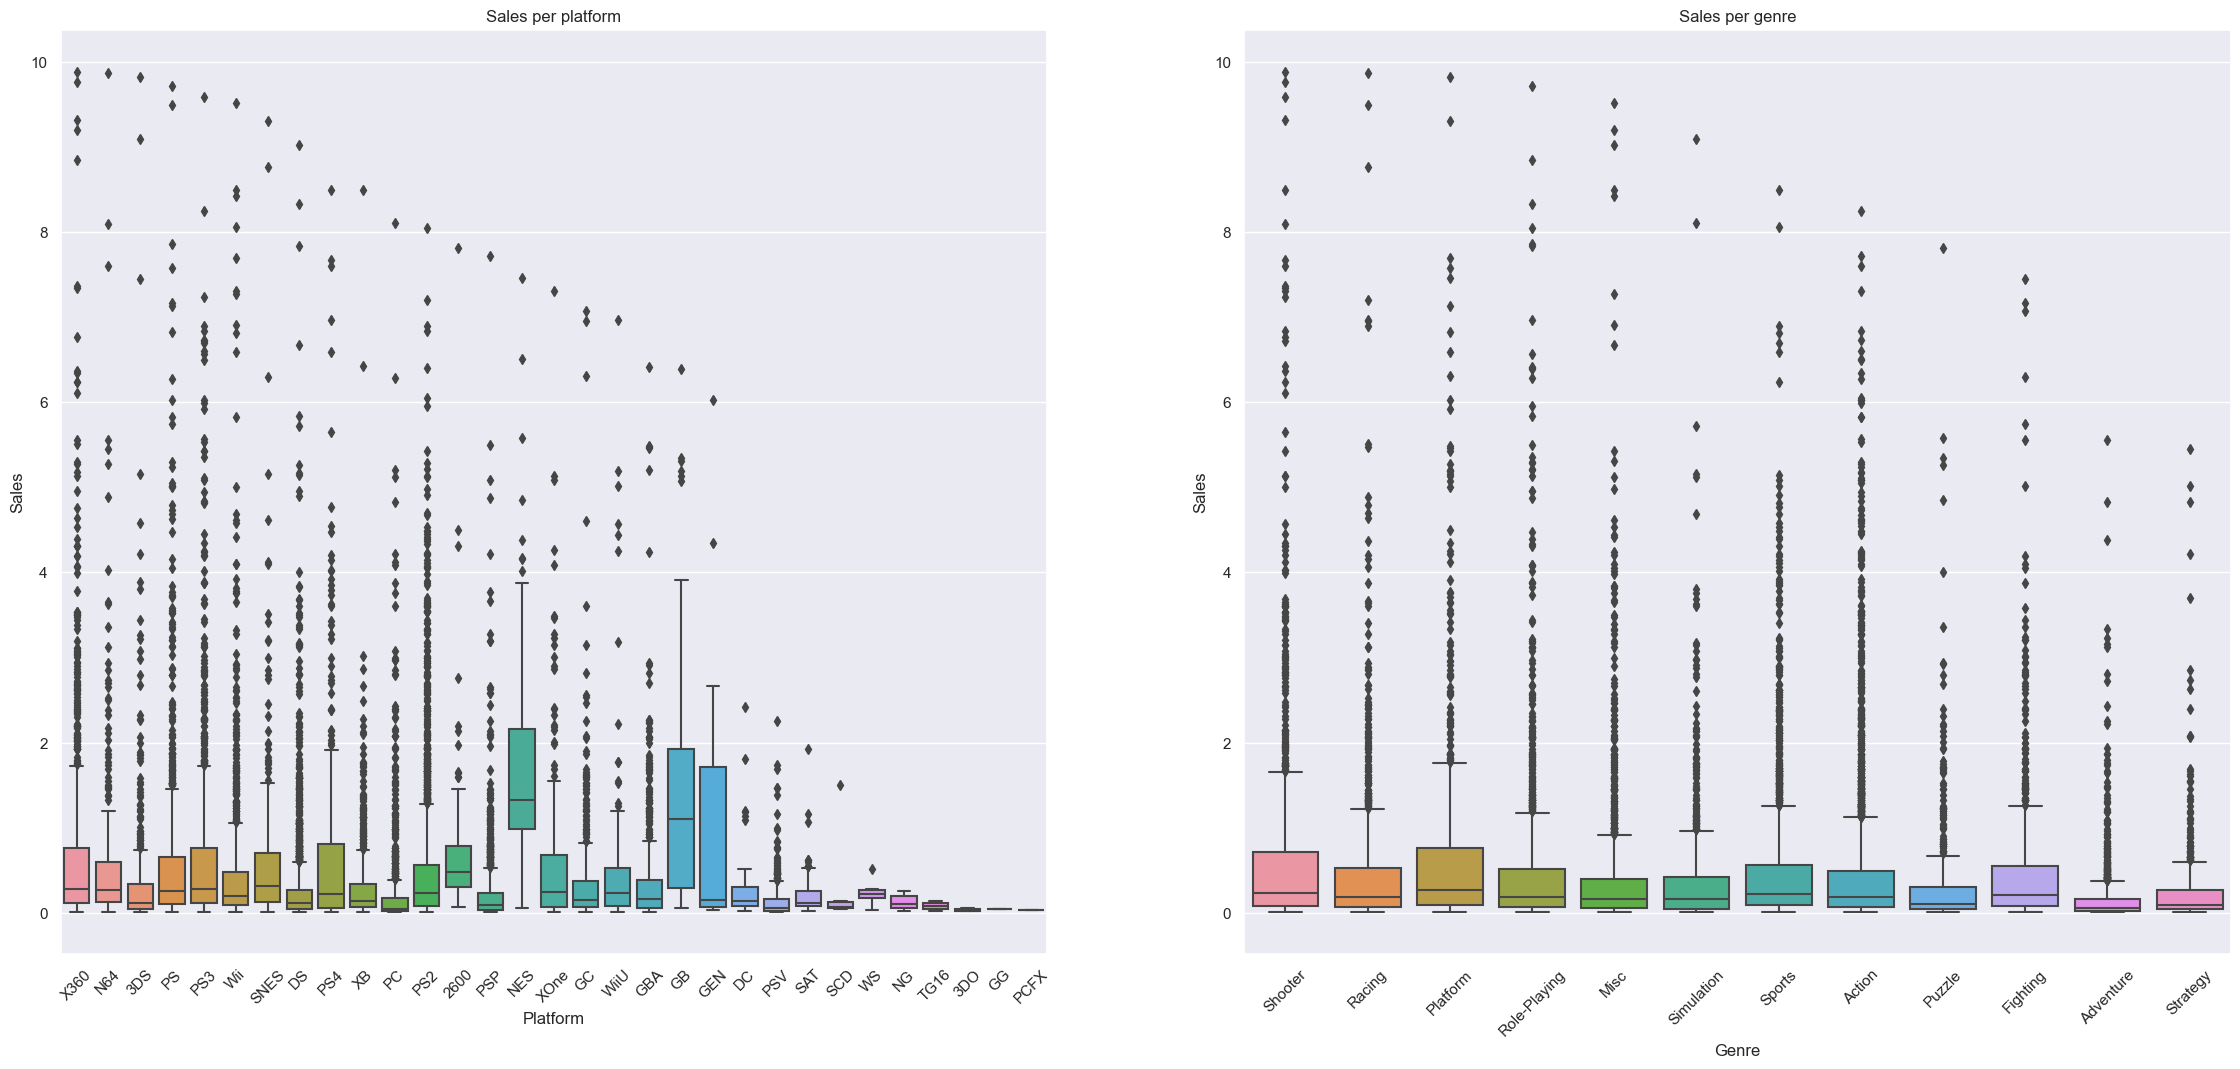

In [16]:
aux = video_game_data.copy()
# There are a lot of outliers, so let's zoom in on the graph
aux = aux[aux['global_sales'] < 10]

plt.subplot(1, 2, 1)
sns.boxplot(x='platform', y='global_sales', data=aux)
plt.title('Sales per platform')
plt.xlabel('Platform')
plt.ylabel('Sales')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='genre', y='global_sales', data=aux)
plt.title('Sales per genre')
plt.xlabel('Genre')
plt.ylabel('Sales')
plt.xticks(rotation=45);

- `First, it is important to understand that we are creating a zoom that removes a lot of outlier behavior.`
- In addition to verifying this outlier behavior, the goal is to understand whether there are different boxplot distributions for each category:
    - There are varied behaviors by platforms, a potential analysis involves grouping by companies as an example the sony consoles and comparing with the others, we can create some hypotheses in the feature engineering session.
    - Gender behavior is difficult to perceive, it would be necessary to analyze some categories more closely to understand their impact on sales.

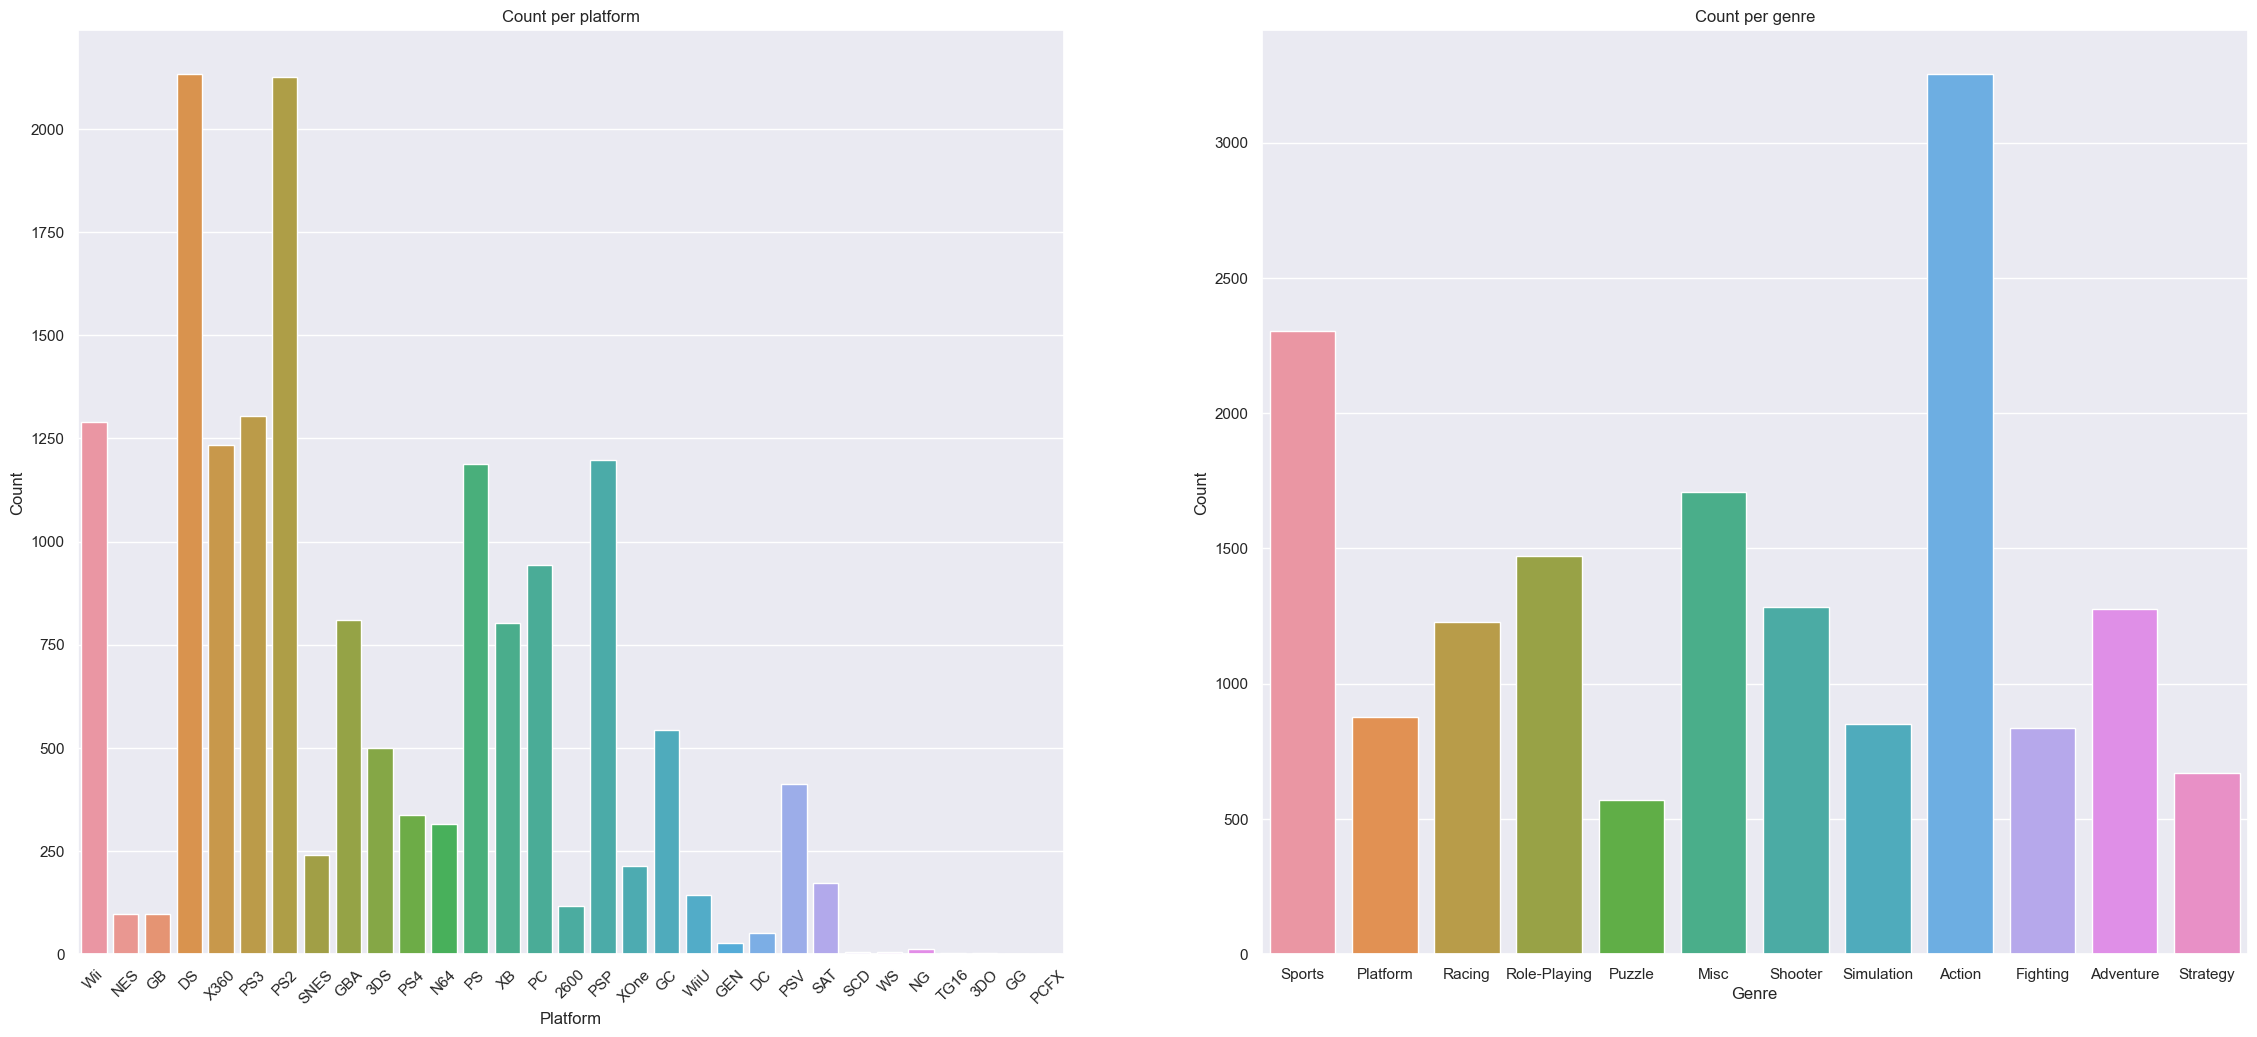

In [17]:
plt.subplot (1, 2, 1)
sns.countplot(x='platform', data=video_game_data)
plt.title('Count per platform')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot (1, 2, 2)
sns.countplot(x='genre', data=video_game_data)
plt.title('Count per genre')
plt.xlabel('Genre')
plt.ylabel('Count');

- In this count chart we can observe gaming trends, we can create assumptions that action games are more in demand by the public than others, as well as games from certain consoles exclusive to Sony, Nintendo and Microsoft, once again we can analyze the platforms by company and better understand these behaviors.

In [18]:
catalog.save("data_description", video_game_data)

[09/21/23 21:57:13] INFO     Saving data to 'data_description' (CSVDataSet)...                  ]8;id=768279;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=519127;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#531\531]8;;\